# Setup the notebook

In [1]:
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set() #sets the matplotlib style to seaborn style

from scipy.ndimage import convolve1d
from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
import os


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

np.random.seed(42)

In [2]:
#We define the parameters RERUN to rerun all the notebook
RERUN = False

# Load and preprocess the data

In [3]:
# Root directory containing the s1, s2, ..., s27 folders
root_dir = "./data/"

# Dictionary to store all loaded .mat files
all_data = {}

# Loop through directories s1 to s27
for i in range(1, 28):
    subdir = os.path.join(root_dir, f"s{i}")  # Construct subdirectory path
    if os.path.exists(subdir):  # Ensure the subdirectory exists
        # Load all .mat files in the subdirectory
        for file in os.listdir(subdir):
            if file.endswith("_A1_E1.mat"):  # Only process .mat files
                print(file)
                file_path = os.path.join(subdir, file)
                all_data[file] = loadmat(file_path)  # Use the filename as the key

print("All files loaded!")


S1_A1_E1.mat
S2_A1_E1.mat
S3_A1_E1.mat
S4_A1_E1.mat
S5_A1_E1.mat
S6_A1_E1.mat
S7_A1_E1.mat
S8_A1_E1.mat
S9_A1_E1.mat
S10_A1_E1.mat
S11_A1_E1.mat
S12_A1_E1.mat
S13_A1_E1.mat
S14_A1_E1.mat
S15_A1_E1.mat
S16_A1_E1.mat
S17_A1_E1.mat
S18_A1_E1.mat
S19_A1_E1.mat
S20_A1_E1.mat
S21_A1_E1.mat
S22_A1_E1.mat
S23_A1_E1.mat
S24_A1_E1.mat
S25_A1_E1.mat
S26_A1_E1.mat
S27_A1_E1.mat
All files loaded!


In [4]:
# Define parameters
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initialize a dictionary to store the processed data
processed_data = {}

# Iterate over all subjects/files
for subject, data in all_data.items():
    print(f"Processing {subject}...")
    
    # Extract variables from the .mat file
    stimulus = data["stimulus"].flatten()  # Ensure 1D
    repetition = data["repetition"].flatten()  # Ensure 1D
    emg = data["emg"]  # EMG signals (assume it's 2D)

    # Get the number of stimuli and repetitions (assume these are known or can be deduced)
    n_stimuli = int(np.max(stimulus))  # Number of unique stimuli
    n_repetitions = int(np.max(repetition))  # Number of unique repetitions

    # Initialize data structures for this subject
    emg_windows = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]
    emg_envelopes = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

    # Process each stimulus and repetition
    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            # Logical indexing to extract the corresponding EMG data
            idx = np.logical_and(
                stimulus == stimuli_idx + 1, 
                repetition == repetition_idx + 1
            ).flatten()
            
            # Extract EMG window and compute its envelope using moving average
            emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
            emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(
                emg_windows[stimuli_idx][repetition_idx], 
                mov_mean_weights, 
                axis=0
            )
    
    # Store processed data for this subject
    processed_data[subject] = {
        "emg_windows": emg_windows,
        "emg_envelopes": emg_envelopes
    }

print("Preprocessing completed for all subjects!")


Processing S1_A1_E1.mat...
Processing S2_A1_E1.mat...
Processing S3_A1_E1.mat...
Processing S4_A1_E1.mat...
Processing S5_A1_E1.mat...
Processing S6_A1_E1.mat...
Processing S7_A1_E1.mat...
Processing S8_A1_E1.mat...
Processing S9_A1_E1.mat...
Processing S10_A1_E1.mat...
Processing S11_A1_E1.mat...
Processing S12_A1_E1.mat...
Processing S13_A1_E1.mat...
Processing S14_A1_E1.mat...
Processing S15_A1_E1.mat...
Processing S16_A1_E1.mat...
Processing S17_A1_E1.mat...
Processing S18_A1_E1.mat...
Processing S19_A1_E1.mat...
Processing S20_A1_E1.mat...
Processing S21_A1_E1.mat...
Processing S22_A1_E1.mat...
Processing S23_A1_E1.mat...
Processing S24_A1_E1.mat...
Processing S25_A1_E1.mat...
Processing S26_A1_E1.mat...
Processing S27_A1_E1.mat...
Preprocessing completed for all subjects!


# Extract the features

In [5]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)

# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope sign changes (SSC)
ssc = lambda x: np.sum(
    ((x[1:-1] - x[:-2]) * (x[2:] - x[1:-1])) < 0,
    axis=0
)

In [6]:

# Function to build dataset from Ninapro data
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    n_samples = n_stimuli * n_repetitions
    n_channels = emg.shape[1]
    n_features = sum(n_channels for feature in features)
    
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            labels[current_sample_index] = i + 1
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            current_feature_index = 0
            for feature in features:
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                current_feature_index += n_channels

            current_sample_index += 1
    
    return dataset, labels

In [10]:
# List of feature names
features = [mav, std, maxav, rms, wl, ssc] 
feature_names = ['MAV', 'STD', 'MaxAV', 'RMS', 'WL', 'SSC']  # Update with your feature names
n_features = len(feature_names)

# Dictionary to store features across subjects
all_feature_values = {feature: [] for feature in feature_names}

# Process each subject and store feature values
for subject, data in all_data.items():
    # Extract stimulus, repetition, and EMG data
    stimulus = data["stimulus"].flatten()  # Ensure 1D
    repetition = data["repetition"].flatten()  # Ensure 1D
    emg = data["emg"]  # EMG signals (assume it's 2D)
    
    # Extract features for the current subject
    subject_dataset, subject_labels = build_dataset_from_ninapro(emg, stimulus, repetition, features)
    
    # Append feature values for this subject
    for feature_idx, feature_name in enumerate(feature_names):
        all_feature_values[feature_name].append(subject_dataset[:, feature_idx])
    
    print(f"Features extracted for {subject}")

# `all_feature_values` now contains lists of feature values for each subject


Features extracted for S1_A1_E1.mat
Features extracted for S2_A1_E1.mat
Features extracted for S3_A1_E1.mat
Features extracted for S4_A1_E1.mat
Features extracted for S5_A1_E1.mat
Features extracted for S6_A1_E1.mat
Features extracted for S7_A1_E1.mat
Features extracted for S8_A1_E1.mat
Features extracted for S9_A1_E1.mat
Features extracted for S10_A1_E1.mat
Features extracted for S11_A1_E1.mat
Features extracted for S12_A1_E1.mat
Features extracted for S13_A1_E1.mat
Features extracted for S14_A1_E1.mat
Features extracted for S15_A1_E1.mat
Features extracted for S16_A1_E1.mat
Features extracted for S17_A1_E1.mat
Features extracted for S18_A1_E1.mat
Features extracted for S19_A1_E1.mat
Features extracted for S20_A1_E1.mat
Features extracted for S21_A1_E1.mat
Features extracted for S22_A1_E1.mat
Features extracted for S23_A1_E1.mat
Features extracted for S24_A1_E1.mat
Features extracted for S25_A1_E1.mat
Features extracted for S26_A1_E1.mat
Features extracted for S27_A1_E1.mat


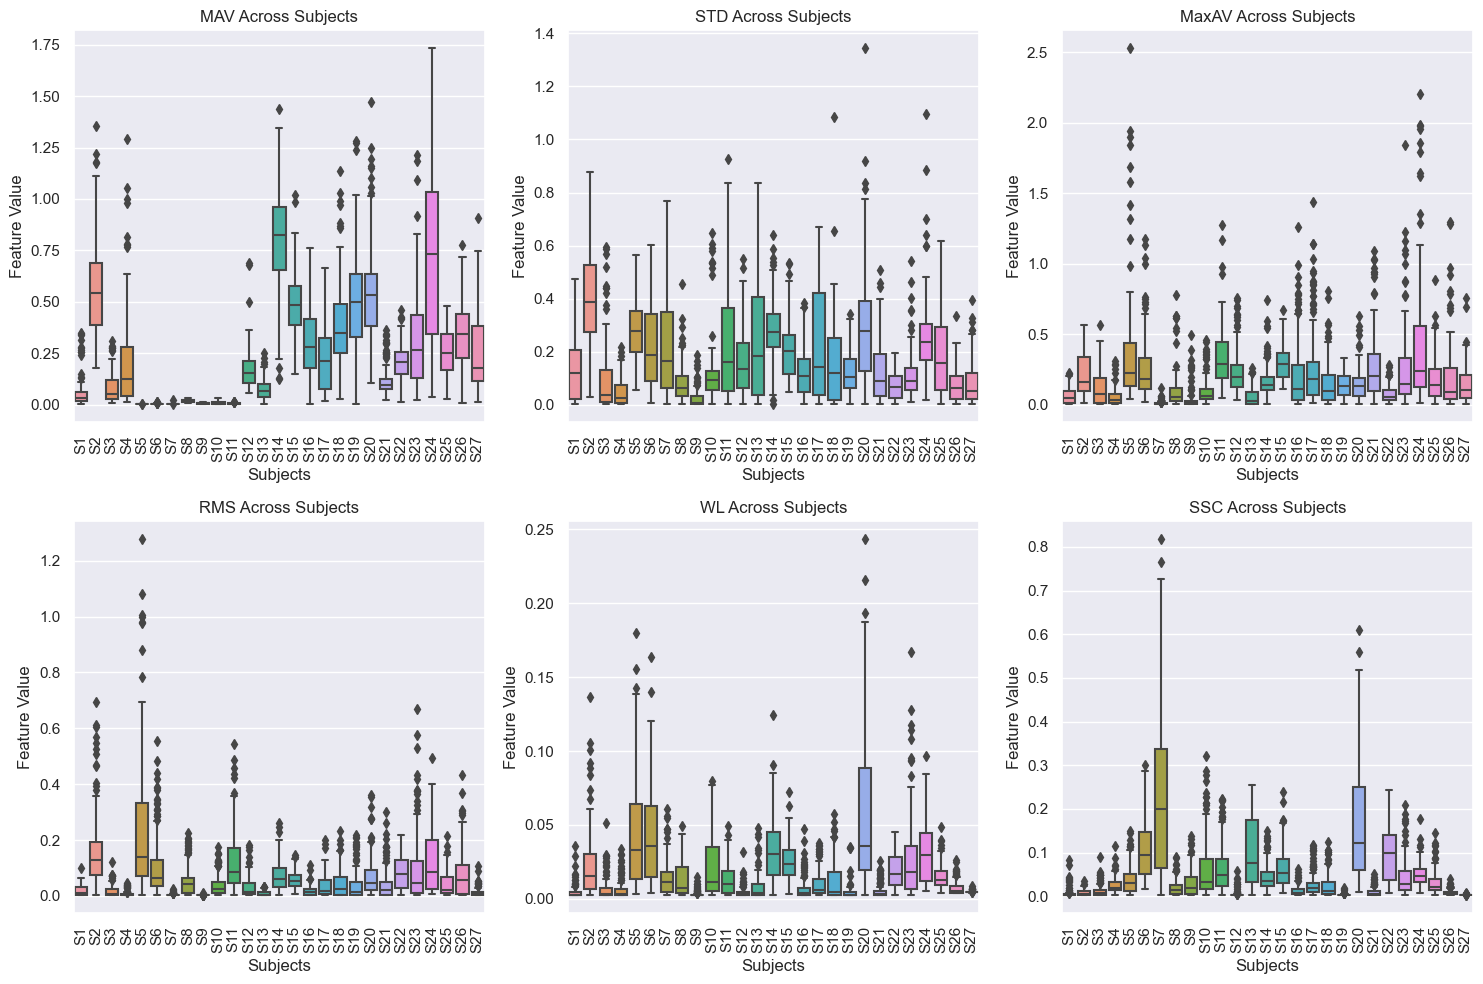

In [12]:
# Now, let's plot these features using box plots to compare across subjects
plt.figure(figsize=(15, 10))

# Loop through all features and create box plots
for idx, feature in enumerate(feature_names):
    plt.subplot(2, 3, idx + 1)
    
    # Box plot for the current feature across subjects
    sns.boxplot(data=all_feature_values[feature])
    plt.title(f"{feature} Across Subjects")
    plt.xlabel('Subjects')
    plt.ylabel('Feature Value')
    plt.xticks(ticks=np.arange(27), labels=[f"S{i+1}" for i in range(27)], rotation=90)
    
plt.tight_layout()
plt.show()


# Perform classification

Validation Accuracy: 0.8301282051282052
Accuracy on test subject S27_A1_E1.mat: 0.2


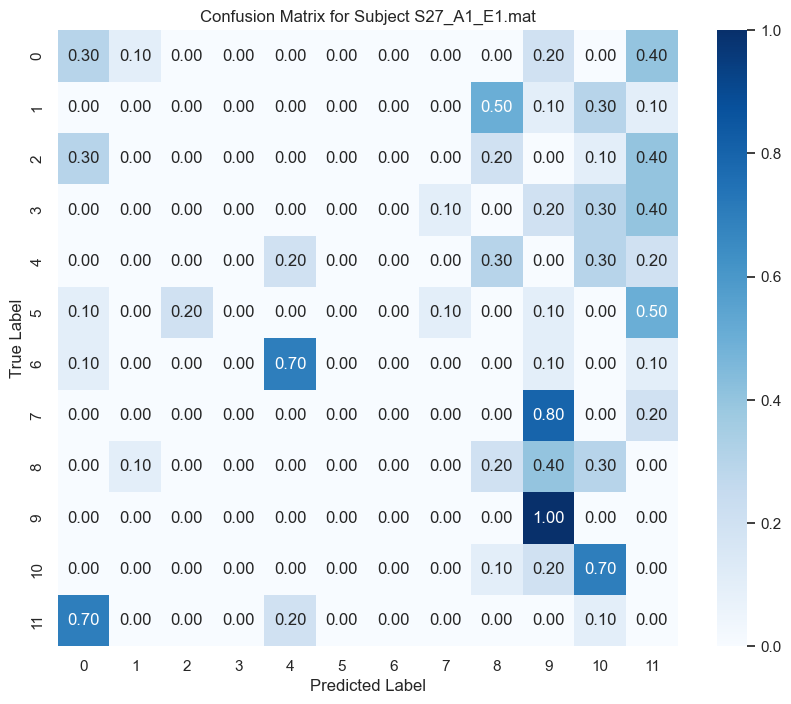

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define features and feature extraction functions
features = [mav, std, maxav, rms, wl, ssc]
feature_names = ['MAV', 'STD', 'MaxAV', 'RMS', 'WL', 'SSC']
n_features = len(feature_names)

# Dictionary to store features for each subject
subject_features = {}

# Process each subject
for subject, data in all_data.items():
    stimulus = data["stimulus"].flatten()  # Ensure 1D
    repetition = data["repetition"].flatten()  # Ensure 1D
    emg = data["emg"]  # EMG signals (assume it's 2D)

    # Extract features for the current subject
    subject_dataset, subject_labels = build_dataset_from_ninapro(emg, stimulus, repetition, features)

    # Store the dataset and labels for the current subject
    subject_features[subject] = {
        "dataset": subject_dataset,
        "labels": subject_labels
    }

# Prepare training and test data
all_subjects = list(subject_features.keys())
n_subjects = len(all_subjects)

# Select the subject to leave out for testing
test_subject = all_subjects[-1]  # Example: Use the last subject as test
train_subjects = [s for s in all_subjects if s != test_subject]

# Combine training data from 26 subjects
X_train_all = np.vstack([subject_features[subj]['dataset'] for subj in train_subjects])
y_train_all = np.hstack([subject_features[subj]['labels'] for subj in train_subjects])

# Split training data into train and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)

# Test data from the left-out subject
X_test = subject_features[test_subject]['dataset']
y_test = subject_features[test_subject]['labels']

# Define parameter grid for Random Forest
param_grid = {
    "n_estimators": [50],  # Add more values for grid search if needed
    "bootstrap": [True],
    "max_features": ["sqrt", "log2", 1, 3, 6, 9, 10, None]
}

# Train a Random Forest Classifier using GridSearchCV
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(X_train, y_train)

# Evaluate on the validation set
y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate on the test subject
y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test subject {test_subject}: {test_accuracy}")

# Confusion matrix
confmat = confusion_matrix(y_test, y_pred, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confmat, annot=True, cmap='Blues', fmt='.2f')
plt.title(f"Confusion Matrix for Subject {test_subject}")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
